## File descriptions

    train.csv - the training set
    test.csv - the test set
    sampleSubmission.csv - a sample submission file in the correct format

## Data fields

    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.linear_model as lr
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
## Загружаем библиотеки моделей
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
ORIGINAL_DATASET_PATH = './data/train.csv' # Оригинальный датасет для обучения
PREPARED_DATASET_PATH = './data/prep_train.csv' # Очищенный датасет
TEST_DATASET_PATH = './data/test.csv' # Данные для проверки модели

In [4]:
orig_df = pd.read_csv(ORIGINAL_DATASET_PATH)
orig_test_df = pd.read_csv(TEST_DATASET_PATH)
X = orig_df.drop('Price', axis=1)
y = orig_df['Price']
X_final = pd.read_csv(TEST_DATASET_PATH)
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()
X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

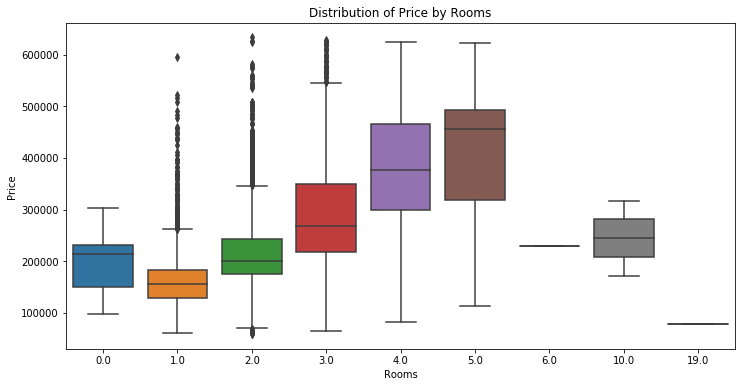

In [5]:
# Большое количество выбросов возможно потребуется скорректировать количество комнат
plt.figure(figsize=(12, 6))
sns.boxplot(orig_df['Rooms'], orig_df['Price'])
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.title('Distribution of Price by Rooms')
plt.show()

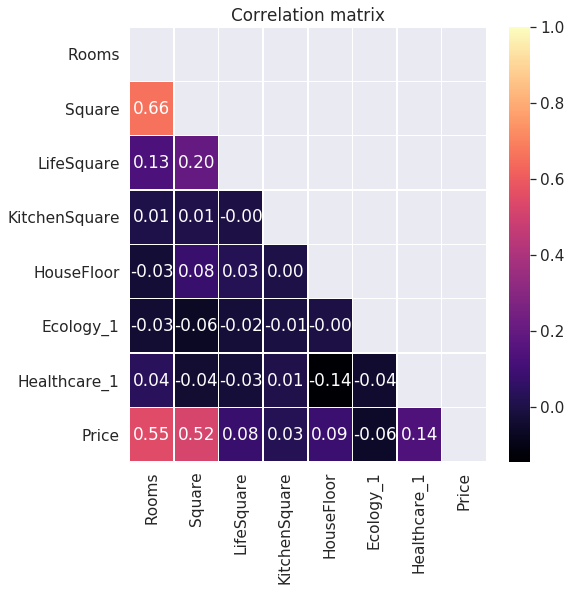

In [6]:
# Выбираем признаки с числовыми значениями float64
df_num_features = orig_df.select_dtypes(include='float64')
num_features = pd.DataFrame(df_num_features)
corr = num_features.corr()
plt.figure(figsize = (8, 8))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.2f', linewidths=.5, cmap='magma')
plt.title('Correlation matrix')
plt.show();

### Сильная корреляция по количеству комнат и площади.

In [7]:
X['DistrictId'] = X['DistrictId']
X_final['DistrictId'] = X_final['DistrictId']

#EDA
Очистка данных от выбросов

In [8]:
X[X['KitchenSquare']>100]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A
7441,62,3.0,114.734473,112.589083,112.0,3,3.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A
12552,58,3.0,116.405693,113.109653,112.0,3,3.0,2016,0.437885,B,B,23,5735,3,1084.0,0,5,B
14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B
2737,27,3.0,123.430072,125.806981,123.0,5,10.0,2015,0.017647,B,B,2,469,0,NaN,0,0,B


In [9]:
X['Rooms'].value_counts() 

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

#### необходимо обработать комнаты с 0 значением и посмотреть значения больше или равные 6-и
#### Можно так же преобразовать количество комнат по году постройки здания исходя из площади 
#### Необходимо учесть комнаты объединенные с кухней предположим если площадь кухни была выставлена меньше 3 то считаем квартиру студией, и если по году постройки и медиане площади комнаты меньше площади кухни то так же считаем квартиру студией. 

In [10]:
class FeatureClear:
    
    def __init__(self):
        self.medians=None
        self.modas=None
        
    def fit(self, X):
        self.medians = X.median()
        self.modas = X.mode().head(1).iloc[0]
    
    def transform(self, X):
        
        X['Correction_count'] = 0
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        X.loc[X['Rooms_outlier']==1, 'Correction_count'] = X['Correction_count'] + 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.modas['Rooms']
        
        
        
        
        
        
        # KitchenSquare
        X['is_studia'] = 0
        X.loc[((X['KitchenSquare'] <= 50) | (X['KitchenSquare'] >= 3)), 'KitchenSquare_new'] = X['KitchenSquare']
        X.loc[((X['KitchenSquare'] > 50) | (X['KitchenSquare'] < 3)), 'is_studia'] = 1
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare_new'] = 3
        X.loc[X['KitchenSquare'] > 50, 'KitchenSquare_new'] = self.medians['KitchenSquare']
        

        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        X.loc[(X['Floor'] > X['HouseFloor'])|(X['HouseFloor'] == 0), 'Correction_count'] = X['Correction_count'] + 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = self.medians['HouseFloor']
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1       
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = self.modas['HouseYear']
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['Old_Square'] = X['Square']
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        X['Old_LifeSquare'] = X['LifeSquare']
        X['Old_Square_summ'] = X['Old_Square']-X['Old_LifeSquare']
        X.loc[((X['Square']-X['LifeSquare'])<0),'Square'] = X['Old_LifeSquare']
        X.loc[((X['Square']-X['LifeSquare'])<0),'LifeSquare'] = X['Old_Square']
        X.loc[X['Square'] >= 300, 'Square'] = self.medians['Square']
        X['LifeSquare_outlier'] = 0
        X.loc[(X['LifeSquare'].isna())|(X['Old_Square_summ']<0), 'LifeSquare_outlier'] = 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        return X

In [11]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.med_room_square_by_year = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 20]  ## Если вы этого не сделаете, то на Leaderboard-е улетите в самый низ (>100 места, R2 ~ 0.65),
                                            ## Хотя на локальной валидации скор вырастет
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
        ## Med meter price by year cat and floor
        if y is not None:
            df['Price'] = y.values
            df['Meter_price']=df['Price']/df['Square']
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_meter_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Meter_price':'median'}).\
                                            rename(columns={'Meter_price':'MedMeterPriceByFloorYear'})
        if y is not None:
            df['Price'] = y.values
            df['Room_square']=(df['Square'] - 10)/df['Rooms']
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_room_square_by_year = df.groupby(['year_cat'], as_index=False).agg({'Room_square':'median'}).\
                                            rename(columns={'Room_square':'Med_room_square'})

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец flooar_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        if self.med_room_square_by_year is not None:
            X = X.merge(self.med_room_square_by_year, on=['year_cat'], how='left')
        # if X['Square'] - X['Med_room_square']*X['Rooms']
                # Rooms
        X.loc[((X['Rooms']* X['Med_room_square']+5) > X['Square']) &  X['is_studia'] == 0, 'Rooms_new'] = \
                                            np.floor(X['Square']/(X['Med_room_square']+X['KitchenSquare_new']))
        X.loc[((X['Rooms']* X['Med_room_square']+5) > X['Square']) &  X['is_studia'] == 1, 'Rooms_new'] = \
                                            np.floor(X['Square']/(X['Med_room_square']+5 ))
        X.loc[X['MedPriceByDistrict'].isna(),'MedPriceByDistrict'] = X['MedPriceByDistrict'].median()
        X.loc[X['MedPriceByFloorYear'].isna(),'MedPriceByFloorYear'] = X['MedPriceByFloorYear'].median()
        
        #X.loc[]
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
    

            
        return X

In [12]:
clearer = FeatureClear()

X[X['MedPriceByDistrict'].isna()]

In [13]:
clearer.fit(X)

In [14]:
X = clearer.transform(X)
X_final = clearer.transform(X_final)

In [15]:
to_del_list = ["Old_LifeSquare","Old_Square_summ"]
X.drop(to_del_list, axis=1, inplace=True)
X_final.drop(to_del_list, axis=1, inplace=True)

In [16]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

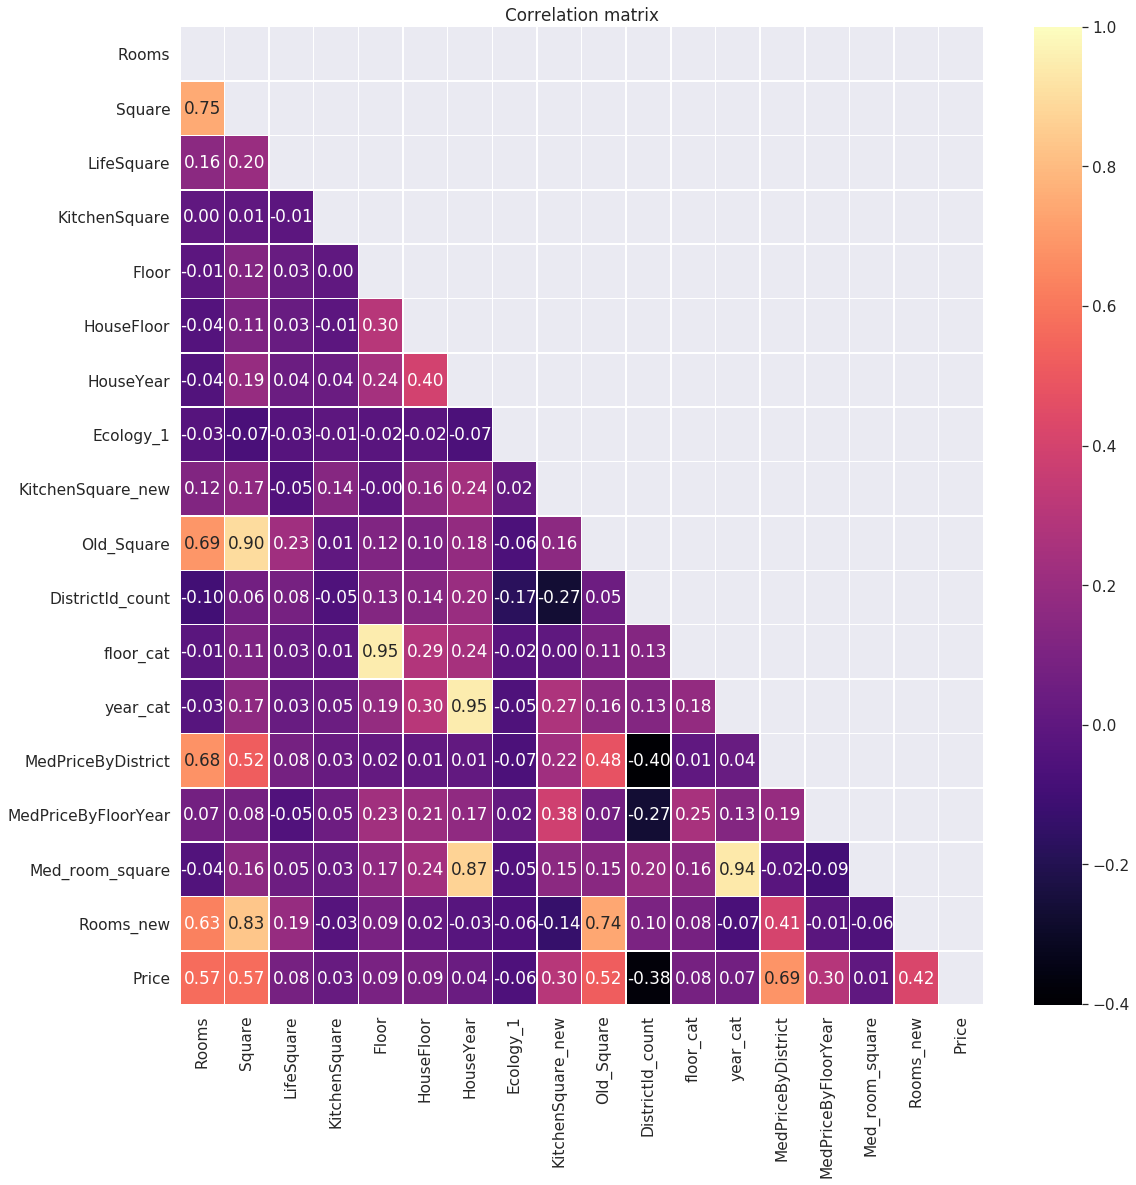

In [17]:
df_num_features = X.select_dtypes(include='float64')
num_features = pd.DataFrame(df_num_features)
num_features['Price'] = y.values
corr = num_features.corr()
plt.figure(figsize = (18, 18))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.2f', linewidths=.5, cmap='magma')
plt.title('Correlation matrix')
plt.show();

In [18]:
X.loc[X['Rooms_new']>5]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,LifeSquare_nan,LifeSquare_outlier,DistrictId_count,new_district,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear,Med_room_square,Rooms_new
590,23,2.0,263.542020,263.542020,5.0,13.0,5.0,1972.0,0.075779,1,...,0,1,565.0,0,4.0,3.0,142883.014837,182431.905609,24.195886,9.0
1812,93,3.0,169.385184,165.385184,1.0,2.0,10.0,1977.0,0.004949,1,...,1,1,73.0,0,1.0,3.0,198524.447471,171916.195050,24.195886,6.0
1981,27,1.0,212.932361,211.231125,0.0,2.0,3.0,2008.0,0.211401,1,...,0,0,851.0,0,1.0,5.0,118349.682906,220135.918847,26.978584,7.0
4047,23,1.0,163.286965,161.155275,1.0,13.0,3.0,1977.0,0.014073,1,...,0,0,565.0,0,4.0,3.0,102069.270740,182431.905609,24.195886,6.0
6201,17,4.0,170.016872,167.016872,0.0,12.0,13.0,1977.0,0.093443,1,...,1,1,59.0,0,4.0,3.0,449653.279868,182431.905609,24.195886,6.0
7084,93,2.0,170.379494,166.379494,1.0,13.0,2.0,1977.0,0.004949,1,...,1,1,73.0,0,4.0,3.0,177282.643824,182431.905609,24.195886,6.0
8131,93,3.0,167.767027,163.767027,1.0,1.0,1.0,1977.0,0.004949,1,...,1,1,73.0,0,1.0,3.0,198524.447471,171916.195050,24.195886,6.0
8646,93,3.0,169.117203,165.117203,1.0,13.0,3.0,1977.0,0.004949,1,...,1,1,73.0,0,4.0,3.0,198524.447471,182431.905609,24.195886,6.0
8913,30,3.0,164.526757,164.526757,0.0,2.0,3.0,1977.0,0.000078,1,...,0,1,228.0,0,1.0,3.0,197817.285170,171916.195050,24.195886,6.0


In [19]:
X.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,LifeSquare_nan,LifeSquare_outlier,DistrictId_count,new_district,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear,Med_room_square,Rooms_new
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.887600,56.289894,41.110355,6.273300,8.812200,12.95910,1984.863800,0.118858,0.990300,...,0.211300,0.259500,241.750000,0.088800,3.104800,3.811900,203906.457040,193917.347913,25.123352,1.358400
std,43.587592,0.811438,19.281937,77.491451,28.560917,4.897278,6.44346,18.409979,0.119025,0.098015,...,0.408251,0.438382,269.472529,0.284469,1.103693,1.168099,68568.903823,25859.535205,1.806254,0.627526
min,0.000000,1.000000,2.377248,-0.140758,0.000000,1.000000,1.00000,1910.000000,0.000000,0.000000,...,0.000000,0.000000,5.000000,0.000000,1.000000,1.000000,82342.775873,155536.339047,21.407700,0.000000
25%,20.000000,1.000000,41.866858,25.355889,1.000000,5.000000,9.00000,1974.000000,0.017647,1.000000,...,0.000000,0.000000,55.000000,0.000000,2.000000,3.000000,165683.084779,182195.527719,24.195886,1.000000
50%,36.000000,2.000000,52.583675,36.243310,6.000000,8.000000,13.00000,1977.000000,0.075424,1.000000,...,0.000000,0.000000,104.000000,0.000000,3.000000,3.000000,187966.419078,182431.905609,24.195886,1.000000
75%,75.000000,2.000000,65.983195,49.114343,9.000000,13.000000,17.00000,2001.000000,0.195781,1.000000,...,0.000000,1.000000,511.000000,0.000000,4.000000,5.000000,232514.855623,205998.692174,26.978584,2.000000
max,209.000000,5.000000,275.645284,7480.592129,2014.000000,42.000000,117.00000,2020.000000,0.521867,1.000000,...,1.000000,1.000000,851.000000,1.000000,5.000000,6.000000,608674.130507,344841.383560,28.709961,9.000000


In [20]:
X.dtypes

DistrictId               int64
Rooms                  float64
Square                 float64
LifeSquare             float64
KitchenSquare          float64
Floor                  float64
HouseFloor             float64
HouseYear              float64
Ecology_1              float64
Ecology_2                int64
Ecology_3                int64
Social_1                 int64
Social_2                 int64
Social_3                 int64
Helthcare_2              int64
Shops_1                  int64
Shops_2                  int64
Correction_count         int64
Rooms_outlier            int64
is_studia                int64
KitchenSquare_new      float64
HouseFloor_outlier       int64
HouseYear_outlier        int64
Old_Square             float64
LifeSquare_nan           int64
LifeSquare_outlier       int64
DistrictId_count       float64
new_district             int64
floor_cat              float64
year_cat               float64
MedPriceByDistrict     float64
MedPriceByFloorYear    float64
Med_room

In [21]:
df1 = X[X.isna().any(axis=1)]
df1# Проверяем на наличе незаполненных полей

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,LifeSquare_nan,LifeSquare_outlier,DistrictId_count,new_district,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear,Med_room_square,Rooms_new




# Удаляю, лишние фичи и те в которых есть незаполненные поля.

In [22]:
to_del_list = ["LifeSquare","Old_Square","Rooms","MedPriceByDistrict","MedPriceByFloorYear"]
X.drop(to_del_list, axis=1, inplace=True)
X_final.drop(to_del_list, axis=1, inplace=True)

In [23]:
df1 = X[X.isna().any(axis=1)]
df1 # Проверяем на наличе незаполненных полей

,DistrictId,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,...,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,LifeSquare_outlier,DistrictId_count,new_district,floor_cat,year_cat,Med_room_square,Rooms_new


In [24]:
model_rfr = RandomForestRegressor(max_depth=15, max_features = 10, n_estimators=600,random_state=100)

In [25]:
model_lgbm = LGBMRegressor(max_depth=5,
                             min_samples_leaf=2,
                             n_estimators=350,
                             random_state=100)

In [26]:
model3 = GradientBoostingRegressor(n_estimators=350, max_depth=5, min_samples_split=4,
                                           learning_rate=0.1, loss='ls', random_state=100)

In [27]:
er = VotingRegressor([('model1', model_lgbm), ('model2', model_rfr),('model3', model3)])

In [28]:
er.fit(X, y)

VotingRegressor(estimators=[('model1',
                             LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=5,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_samples_leaf=2,
                                           min_split_gain=0.0, n_estimators=350,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=100,
                                           reg_alpha=0.0, reg_lambda=0.0,...
                                                       loss='ls', max_depth=5,
                                                

In [29]:
cv_score = cross_val_score(er, X, y, 
                           scoring='r2', 
                           n_jobs=-1,
                           cv=KFold(n_splits=3, shuffle=True, random_state=100))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.6f} +- {:.6f}'.format(mean, std))

R2: 0.758801 +- 0.005362


### Размер датафрэйма небольшой поэтому кросвалидацию провожу на 3-х фолдах. Параметры моделей подбирались на 5-ти фолдах что дает более реальную оценку.

In [30]:
y_pred_final = er.predict(X_final)
preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions_er_c2_v8.csv', index=False)
!kaggle competitions submit -c realestatepriceprediction -m "VotingRegressor 3 models v11 Square fix and Rooms" -f predictions_er_c2_v8.csv

100%|████████████████████████████████████████| 117k/117k [00:07<00:00, 16.0kB/s]
Successfully submitted to Real Estate Price Prediction